In [ ]:
import pathlib
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

from tensorflow.keras import layers, models
from IPython import display

In [ ]:
#Reproductibility
seed  = 42
tf.random.set_seed(seed)
np.random.seed(seed)

#Setting Data path
Dataset_path = 'data'
data_dir = pathlib.Path(Dataset_path)

#Labeling
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands!='README.md']

print(commands)


['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Dataset creation

In [ ]:
train_data, test_data = tf.keras.utils.audio_dataset_from_directory(
    directory=Dataset_path,

    #Train batch size
    batch_size=64,

    #Test split
    validation_split= 0.2,

    #Randomize
    seed = 0,

    output_sequence_length= 16000,
    subset = 'both'
)

label_names = np.array(train_data.class_names)
print(label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Squeeze

In [ ]:
def squeeze (audio, labels):
    audio = tf.squeeze(audio,axis = -1)
    return audio, labels

train_data = train_data.map(squeeze, tf.data.AUTOTUNE)
test_data = test_data.map(squeeze, tf.data.AUTOTUNE)

Split 80 10 testing 10 validation

In [ ]:
testing_data = test_data.shard(num_shards=2, index = 0)
validation_data = test_data.shard(num_shards=2, index = 1)


Feature Extraction

In [ ]:
def getSpectogram(waveform):
    spectogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128
        )

    #Obtained magnitude
    spectogram = tf.abs(spectogram)

    spectogram = spectogram[..., tf.newaxis]
    return spectogram

In [ ]:
def make_spec_dataset(dataset):
    return dataset.map(
        map_func= lambda audio, label : (getSpectogram(audio), label),
        num_parallel_calls = tf.data.AUTOTUNE
    )

In [ ]:
train_spectogram_data = make_spec_dataset(train_data)
validation_spectogram_data = make_spec_dataset(validation_data)
testing_data_spectogram_data = make_spec_dataset(testing_data)

In [ ]:
#Nentuin shape input
for example_spectogram, example_spectogram_labels in train_spectogram_data.take(1):
    break

#shuffle buat training
train_spectogram_data = train_spectogram_data.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)


validation_spectogram_data = validation_spectogram_data.cache().prefetch(tf.data.AUTOTUNE)
testing_data_spectogram_data = testing_data_spectogram_data.cache().prefetch(tf.data.AUTOTUNE)

norm_layers = layers.Normalization()
norm_layers.adapt(data = train_spectogram_data.map(map_func = lambda spec, labels : spec))

In [ ]:
num_labels = len(commands)
input_shape = example_spectogram.shape[1:]

In [ ]:
model = models.Sequential([
    layers.Input(shape = input_shape),
    layers.Resizing(32,32),
    norm_layers,
    layers.Conv2D(32,3, activation = 'relu'),
    layers.Conv2D(64,3, activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0,25),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
]
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_11 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 flatten_4 (Flatten)         (None, 12544)             0         
                                                        

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)

Training

In [ ]:
#Hyperparameter
epoch = 10

history = model.fit(
    train_spectogram_data,
    validation_data = validation_spectogram_data,
    epochs = epoch,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose=1,patience=2)
)

Epoch 1/10
100/100 [==============================] - 25s 233ms/step - loss: 1.7206 - accuracy: 0.3739 - val_loss: 1.2990 - val_accuracy: 0.6042
Epoch 2/10
100/100 [==============================] - 12s 119ms/step - loss: 1.1588 - accuracy: 0.5956 - val_loss: 0.9050 - val_accuracy: 0.7305
Epoch 3/10
100/100 [==============================] - 12s 116ms/step - loss: 0.8540 - accuracy: 0.7044 - val_loss: 0.7177 - val_accuracy: 0.7852
Epoch 4/10
100/100 [==============================] - 11s 112ms/step - loss: 0.7021 - accuracy: 0.7570 - val_loss: 0.6117 - val_accuracy: 0.8216
Epoch 5/10
100/100 [==============================] - 11s 114ms/step - loss: 0.5976 - accuracy: 0.7903 - val_loss: 0.5540 - val_accuracy: 0.8177
Epoch 6/10
100/100 [==============================] - 11s 114ms/step - loss: 0.4943 - accuracy: 0.8256 - val_loss: 0.4999 - val_accuracy: 0.8503
Epoch 7/10
100/100 [==============================] - 11s 113ms/step - loss: 0.4353 - accuracy: 0.8486 - val_loss: 0.4843 - val_ac

Plotting

Text(0, 0.5, 'ACCURACY')

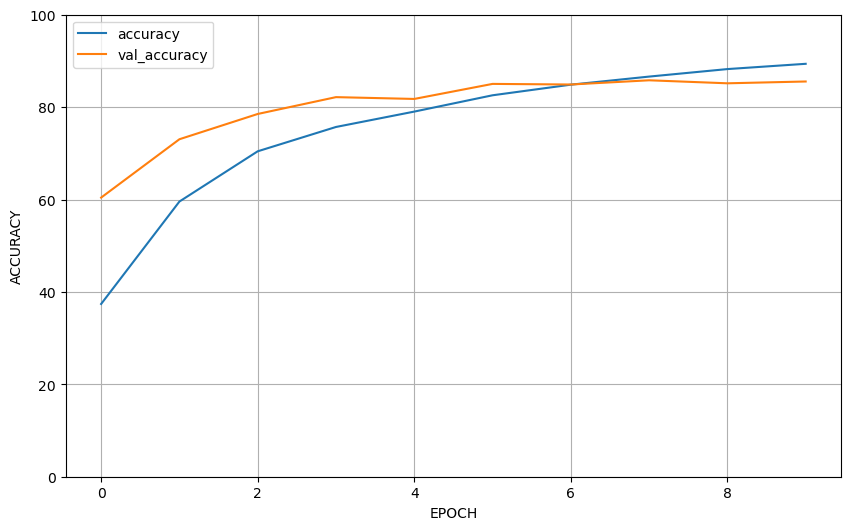

In [ ]:
metrics = history.history
plt.figure(figsize=(10,6))
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics ['val_accuracy']))
plt.legend(['accuracy','val_accuracy'])
plt.grid(visible=True)
plt.ylim(0,100)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')

In [ ]:
test_results = model.evaluate(testing_data_spectogram_data, return_dict= True)
accuracy = test_results['accuracy']
print('Accuracy on testing dataset:',accuracy)

13/13 [==============================] - 2s 124ms/step - loss: 0.4796 - accuracy: 0.8450
Accuracy on testing dataset: 0.8449519276618958


In [ ]:
ctr = 0

for i, (spectogram, labels) in enumerate(testing_data_spectogram_data):
    pred = model.predict(spectogram)
    pred_labels_idx = tf.argmax(pred,axis=1).numpy()
    orig_label = label_names[labels.numpy()]
    pred_label = [label_names[idx] for idx in pred_labels_idx]

    for j, label in enumerate(orig_label):
        ctr+=1
        print("Data no.%d: %-15s %-9s %-12s '%s'"%(ctr, 'Original label: ',label, 'Prediction: ',pred_label[j]))


2/2 [==============================] - 0s 14ms/step
Data no.1: Original label:  up        Prediction:  'up'
Data no.2: Original label:  yes       Prediction:  'yes'
Data no.3: Original label:  up        Prediction:  'go'
Data no.4: Original label:  up        Prediction:  'up'
Data no.5: Original label:  down      Prediction:  'down'
Data no.6: Original label:  stop      Prediction:  'stop'
Data no.7: Original label:  yes       Prediction:  'no'
Data no.8: Original label:  down      Prediction:  'down'
Data no.9: Original label:  left      Prediction:  'left'
Data no.10: Original label:  left      Prediction:  'left'
Data no.11: Original label:  go        Prediction:  'go'
Data no.12: Original label:  stop      Prediction:  'go'
Data no.13: Original label:  no        Prediction:  'no'
Data no.14: Original label:  go        Prediction:  'go'
Data no.15: Original label:  right     Prediction:  'right'
Data no.16: Original label:  down      Prediction:  'down'
Data no.17: Original label:  